# Introduction:

"Can we build a Machine Learning model to act as a Football Scout? In this notebook, I use Random Forest to predict the 'Fair Market Value' of players and identify which ones are underpaid."

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-player-2026-synthetic-regression-data/synthetic_football_stats_2025.csv


# Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
colors = ["#1A2C5B", "#FFD700"]

# 1. Load Data

In [3]:
df = pd.read_csv("/kaggle/input/football-player-2026-synthetic-regression-data/synthetic_football_stats_2025.csv")

In [4]:
print(f"⚽ Data Loaded: {df.shape[0]} players")
display(df.head(3))

⚽ Data Loaded: 1000 players


,Player_ID,Team,Position,Age,Matches,Goals,Assists,xG,Pass_Accuracy,Salary_M_Euro
0,1000,Inter Milan,DF,24,29,1,1,0.94,83.9,4.70
1,1001,Real Madrid,FW,33,19,8,4,6.71,88.7,12.37
2,1002,PSG,MF,19,19,1,3,0.89,76.6,7.14


# 2. Feature Engineering

In [5]:
df['Goals_Per_Match'] = df['Goals'] / df['Matches']
df['Goal_Contribution'] = df['Goals'] + df['Assists']
df['xG_Diff'] = df['Goals'] - df['xG']

In [6]:
# Drop players with 0 matches to avoid division errors
df = df[df['Matches'] > 0]

# 2.1 Visualization

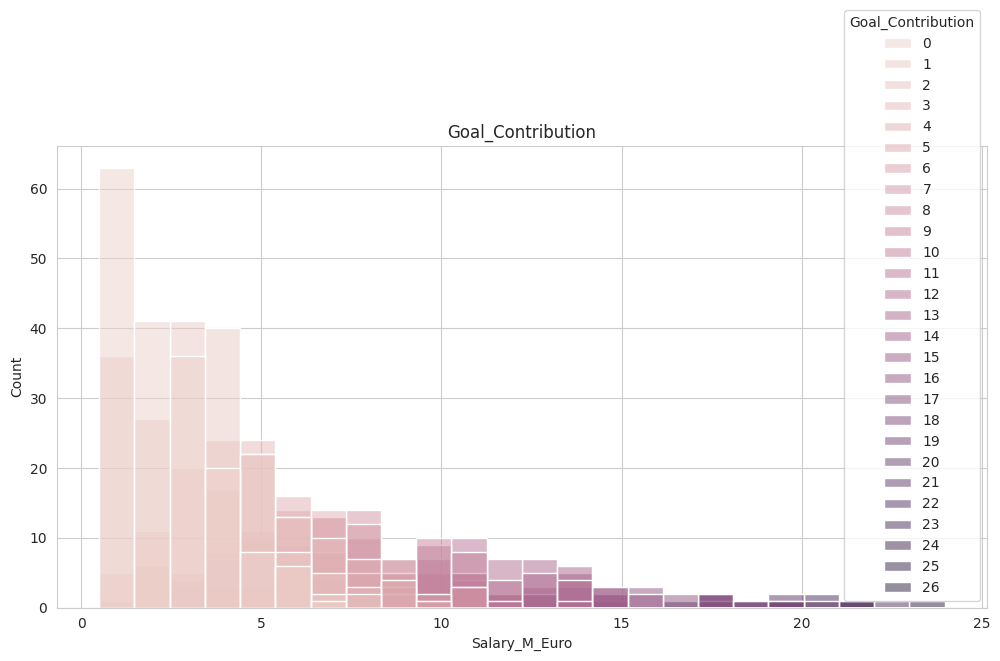

In [7]:
sns.histplot(x="Salary_M_Euro",hue="Goal_Contribution",data=df)
plt.title("Goal_Contribution")
plt.show()

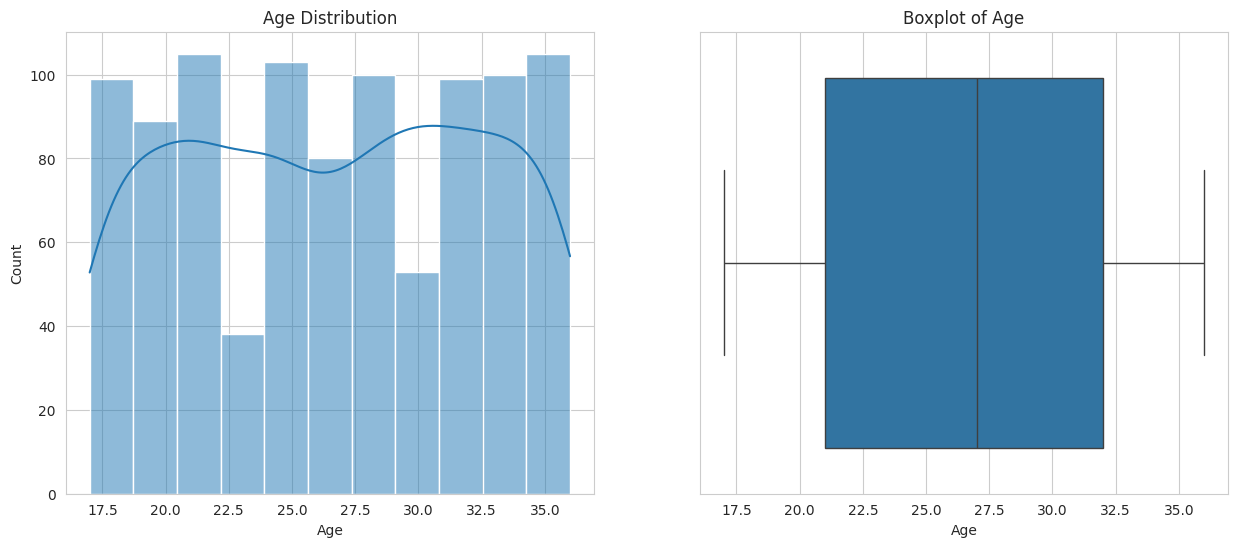

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(x="Age",kde=True,data=df)
plt.title("Age Distribution")

plt.subplot(1,2,2)
sns.boxplot(x="Age",data=df)
plt.title("Boxplot of Age")

plt.show()

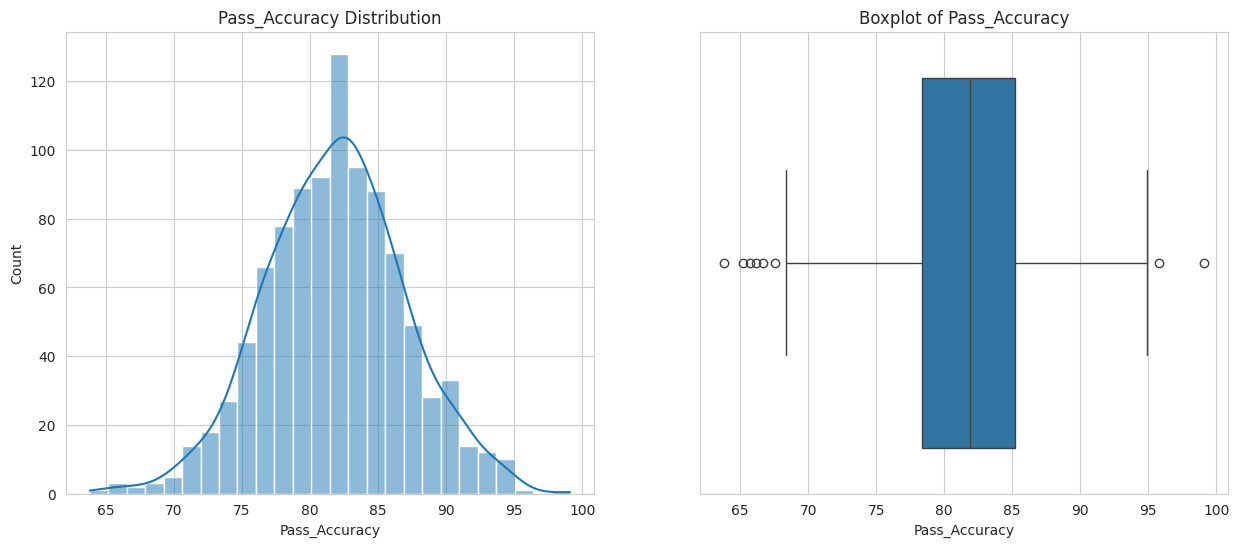

In [9]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(x="Pass_Accuracy",kde=True,data=df)
plt.title("Pass_Accuracy Distribution")

plt.subplot(1,2,2)
sns.boxplot(x="Pass_Accuracy",data=df)
plt.title("Boxplot of Pass_Accuracy")

plt.show()

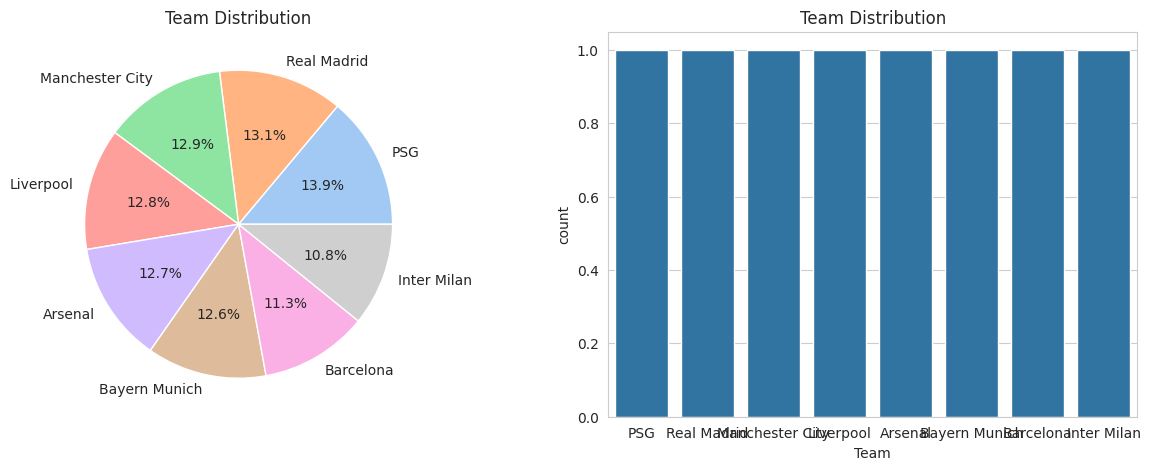

In [10]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
x = df["Team"].value_counts()
plt.pie(x, labels=x.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Team Distribution")

plt.subplot(1,2,2)
sns.countplot(x)
plt.title("Team Distribution")
plt.show()

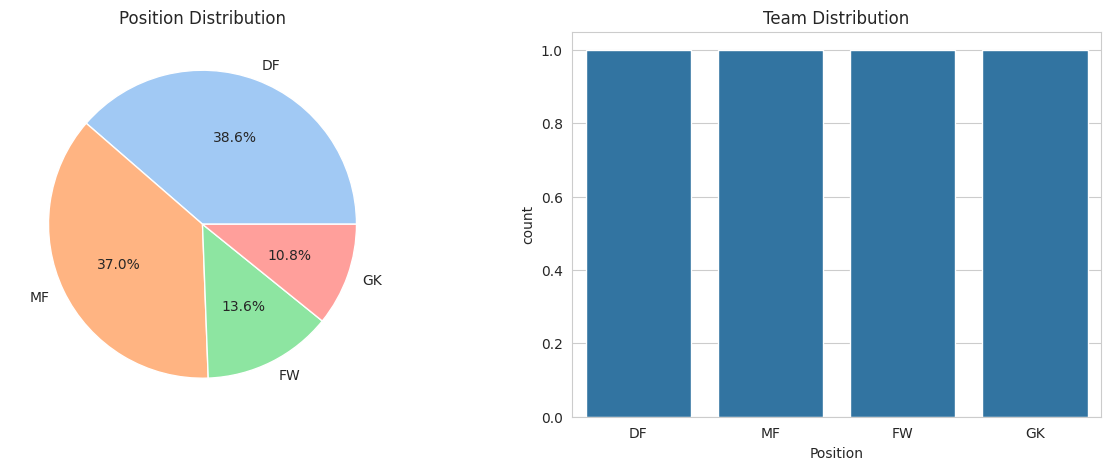

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
x = df["Position"].value_counts()
plt.pie(x, labels=x.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Position Distribution")

plt.subplot(1,2,2)
sns.countplot(x)
plt.title("Team Distribution")
plt.show()

# 3. Feature Selection

In [12]:
# 3. PREPARE MODEL
# We want to predict Salary based on Performance
features = ['Age', 'Goals', 'Assists', 'Matches', 'Pass_Accuracy', 'Goals_Per_Match', 'xG_Diff']
target = 'Salary_M_Euro'

X = df[features]
y = df[target]

# 4. Data Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Fit Model

In [14]:
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

# 6. Model Evaluation

In [15]:
# Evaluate
preds = model.predict(X_test)
print(f"✅ Model R2 Score: {r2_score(y_test, preds):.2f}")
print(f"💰 Average Error in Prediction: €{mean_absolute_error(y_test, preds):.2f}M")

✅ Model R2 Score: 0.91
💰 Average Error in Prediction: €1.05M


# 7. Results

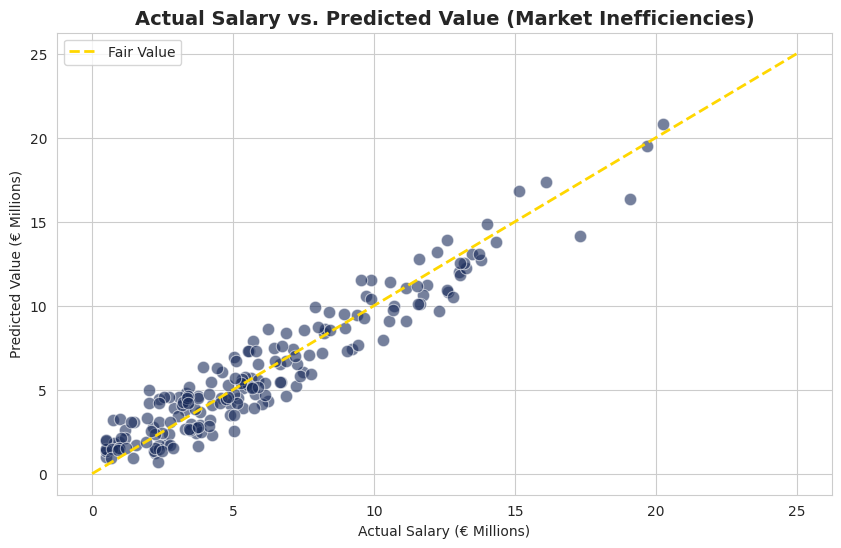


💎 TOP 5 UNDERVALUED PLAYERS (Sign them now!):


,Team,Position,Goals,Salary_M_Euro,Predicted_Salary,Value_Diff
689,Liverpool,MF,1,2.02,4.953830,2.933830
91,PSG,MF,0,0.75,3.200954,2.450954
113,Manchester City,MF,2,3.95,6.359886,2.409886
243,Bayern Munich,MF,3,6.25,8.629156,2.379156
316,Liverpool,DF,0,1.00,3.280542,2.280542


In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=preds, color=colors[0], alpha=0.6, s=80)

# Ideal line (Perfect prediction)
plt.plot([0, 25], [0, 25], '--', color=colors[1], linewidth=2, label="Fair Value")

plt.title("Actual Salary vs. Predicted Value (Market Inefficiencies)", fontsize=14, fontweight='bold')
plt.xlabel("Actual Salary (€ Millions)")
plt.ylabel("Predicted Value (€ Millions)")
plt.legend()
plt.show()

# 6. FIND THE GEMS (Top 5 Undervalued Players)
# Calculate the difference
test_indices = X_test.index
results = df.loc[test_indices].copy()
results['Predicted_Salary'] = preds
results['Value_Diff'] = results['Predicted_Salary'] - results['Salary_M_Euro']

# Sort by biggest difference (Predicted > Actual)
undervalued = results.sort_values(by='Value_Diff', ascending=False).head(5)

print("\n💎 TOP 5 UNDERVALUED PLAYERS (Sign them now!):")
display(undervalued[['Team', 'Position', 'Goals', 'Salary_M_Euro', 'Predicted_Salary', 'Value_Diff']])

# The Conclusion:

"Our model achieved an R2 Score of 0.91. The scatter plot shows a clear linear trend, but the 'Outliers' below the line represent potential bargains for any club manager!"

# Thanks!

---